# Demonstrate using Crank-Nicholson scheme to solve for Richards equations
This Jupyter notebook uses the `srt`, `sstep`, and `rosr` subroutines from the Noah land surface model to demonstrate using Crank-Nicholson scheme to solve for Richards equations.

The soil model is described as below:
Soil matric potential
\begin{equation}\tag{1}
\Psi(\Theta) = \Psi_s\left(\Theta/\Theta_s\right)^{-b}\text{,}
\end{equation}
where $\Theta$ is the volumetric soil moisture, $\Theta_s$ is the soil porosity, $\Psi_s$ is the air entry water potential, and $b$ is the slope of $\ln\Psi$ vs. $\ln\Theta$.

Hydraulic conductivity
\begin{equation}\tag{2}
K(\Theta) = K_s\left(\Theta/\Theta_s\right)^{2b+3}\text{,}
\end{equation}
where $K_s$ is the saturated hydraulic conductivity.

The water diffusivity is
\begin{align}
&D(\Theta) = K(\Theta)\frac{\partial \Psi}{\partial \Theta}\notag\\
= &K_s\left(\frac{\Theta}{\Theta_s}\right)^{2b+3}\left(-b\right)\Psi_s\frac{1}{\Theta_s}\left(\frac{\Theta}{\Theta_s}\right)^{-b-1}\notag\\
=&-b\frac{\Psi_s}{\Theta_s}K_s\left(\frac{\Theta}{\Theta_s}\right)^{b+2}\notag\text{.}
\end{align}
Because
\begin{equation}
D(\Theta_s) = K_s \left(\frac{\partial \Psi}{\partial \Theta}\right)\vert_{\Theta=\Theta_s}=-bK_s\frac{\Psi_s}{\Theta_s}\text{,}\notag
\end{equation}
we have
\begin{equation}\tag{3}
D(\Theta) = D(\Theta_s)\left(\frac{\Theta}{\Theta_s}\right)^{b+2}\text{.}
\end{equation}

The soil hydraulic parameters, initial volumetric soil water content, precipitation, surface runoff, and evapotranspiration come from a Noah land surface model simulation.
The porosity $\Theta_s$ is $0.464\text{~m}^3\text{~m}^{-3}$;
the air entry water potential $\Psi_s$ is $0.62\text{~m}$,
the saturated hydraulic conductivity $K_s$ is $0.2\times 10^{-5}\text{~m~s}^{-1}$,
and the $b$ exponent is $8.72$.
Time step is $30$ minutes.
The soil layers are defined as in the Noah land surface model, which has four layers, with depths of $0.1$, $0.3$, $0.6$, and $1.0$ m, from top to bottom.


## Define soil parameters and layers

In [74]:
# Soil parameters
SMCMAX = 0.464  # m3/m3
SATPSI = 0.62   # m
DKSAT = 0.20E-5 # m/s
BEXP = 8.72     # -
DWSAT = BEXP * DKSAT * SATPSI / SMCMAX
SLOPE = 0.1     # -

# Time step
DT = 30.0 * 60.0    # s

def wdfcnd(smc):
    factr2 = min(1.0, max(0.0, smc / SMCMAX))
    expon = BEXP + 2.0
    wdf = DWSAT * (factr2 ** expon)     # Equation 3

    expon = 2.0 * BEXP + 3.0
    wcnd = DKSAT * (factr2 ** expon)    # Equation 2

    return wdf, wcnd

swc = [[0.3568, 0.3601, 0.3669, 0.3793]]
nsoil = 4
zsoil = [-0.1, -0.4, -1.0, -2.0]
dsoil = [0.1, 0.3, 0.6, 1.0]

## Read precipitation, surface runoff, and evapotranspiration

In [75]:
import pandas as pd

noah_df = pd.read_csv('./HYDRO.TXT',
    sep='\s+',
)

pddum_array = (noah_df['PRCP'] - noah_df['RUNOFF11']) / 1000.0 / DT   # from mm to m/s
edir_array = noah_df['EDIR1S'] / 1000.0 / DT
et_array = noah_df['ETT1S'] / 1000.0 / DT

## Functions to solve Richards equations using Crank-Nicholson scheme

In [76]:
def srt(swc, pddum, edir, et):
    """Calculate the right hand side of the time tendency term of the soil water diffusion equation. Also compute
    (prepare) the matrix coefficients for the tri-diagonal matrix of the implicit time scheme.
        rhstt    - soil water time tendency
        runoff2  - sub surface runoff (baseflow)
        ai       - matrix coefficients
        bi       - matrix coefficients
        ci       - matrix coefficients
    """
    # Initialize the matrix coefficients and the right hand side of the soil water equation
    ai = [None] * nsoil
    bi = [None] * nsoil
    ci = [None] * nsoil
    rhstt = [None] * nsoil

    # Calculate the soil water diffusivity and hydraulic conductivity for the top layer
    wdf, wcnd = wdfcnd(swc[0])

    # Calculate the matrix coefficients ai, bi, and ci for the top layer
    ddz = 1.0 / (-0.5 * zsoil[1])
    ai[0] = 0.0
    bi[0] = wdf * ddz / (-zsoil[0])
    ci[0] = -bi[0]

    # Calculate rhstt for the top layer after calculating the vertical soil moisture gradient between the top and next
    # to top layers
    dsmdz = (swc[0] - swc[1]) / (-0.5 * zsoil[1])
    rhstt[0] = (wdf * dsmdz + wcnd - pddum + edir + et[0]) / zsoil[0]

    # Initialize ddz2
    ddz2 = 0.0

    # Loop through the remaining soil layers, repeating the above process
    for k in range(1, nsoil):
        denom2 = zsoil[k-1] - zsoil[k]

        # Slope of bottom layer is introduced
        slopx = SLOPE if k == nsoil - 1 else 1.0

        # retrieve the soil water diffusivity and hydraulic conductivity for this layer
        wdf2, wcnd2 = wdfcnd(swc[k])

        if k < nsoil - 1:
            # Calculate some partial products for later use in calculating rhstt
            denom = zsoil[k-1] - zsoil[k+1]
            dsmdz2 = (swc[k] - swc[k+1]) / (denom * 0.5)

            # Calculate the matrix coef, ci, after calculating its partial product
            ddz2 = 2.0 / denom
            ci[k] = -wdf2 * ddz2 / denom2
        else:   # k == nsoil - 1
            # Calculate a partial product for later use in calculating rhstt
            dsmdz2 = 0.0

            # Set matrix coef ci to zero
            ci[k] = 0.0

        # Calculate rhstt for this layer after calculating its numerator
        numer = wdf2 * dsmdz2 + slopx * wcnd2 - wdf * dsmdz - wcnd + et[k]
        rhstt[k] = numer / (-denom2)

        # Calculate matrix coefficients, ai, and bi for this layer
        ai[k] = -wdf * ddz / denom2
        bi[k] = -(ai[k] + ci[k])

        # Reset values of wdf, wcnd, dsmdz, and ddz for loop to next layer
        # runoff2:  sub-surface or baseflow runoff
        if k == nsoil - 1:
            runoff2 = slopx * wcnd2
        else:
            wdf = wdf2
            wcnd = wcnd2
            dsmdz = dsmdz2
            ddz = ddz2

    return ai, bi, ci, rhstt


def rosr12(a, b, d, c):
    """rosr12 inverts (solve) the tri-diagonal matrix problem shown below:
        ###                                            ### ###  ###   ###  ###
        #b(1), c(1),  0  ,  0  ,  0  ,   . . .  ,    0   # #      #   #      #
        #a(2), b(2), c(2),  0  ,  0  ,   . . .  ,    0   # #      #   #      #
        # 0  , a(3), b(3), c(3),  0  ,   . . .  ,    0   # #      #   # d(3) #
        # 0  ,  0  , a(4), b(4), c(4),   . . .  ,    0   # # p(4) #   # d(4) #
        # 0  ,  0  ,  0  , a(5), b(5),   . . .  ,    0   # # p(5) #   # d(5) #
        # .                                          .   # #  .   # = #   .  #
        # .                                          .   # #  .   #   #   .  #
        # .                                          .   # #  .   #   #   .  #
        # 0  , . . . , 0 , a(m-2), b(m-2), c(m-2),   0   # #p(m-2)#   #d(m-2)#
        # 0  , . . . , 0 ,   0   , a(m-1), b(m-1), c(m-1)# #p(m-1)#   #d(m-1)#
        # 0  , . . . , 0 ,   0   ,   0   ,  a(m) ,  b(m) # # p(m) #   # d(m) #
        ###                                            ### ###  ###   ###  ###
    """
    p = [None] * nsoil
    delta = [None] * nsoil


    # Initialize equation coefficient c for the lowest soil layer
    c[nsoil - 1] = 0.0

    # Solve the coefficients for the 1st soil layer
    p[0] = -c[0] / b[0]
    delta[0] = d[0] / b[0]

    # Solve the coefficients for soil layers 2 through nsoil
    for k in range(1, nsoil):
        p[k] = -c[k] * (1.0 / (b[k] + a[k] * p[k - 1]))
        delta[k] = (d[k] - a[k] * delta[k - 1]) * (1.0 / (b[k] + a[k] * p[k - 1]))

    # Set p to delta for lowest soil layer
    p[nsoil - 1] = delta[nsoil - 1]

    # Adjust p for soil layers 2 through nsoil
    for k in range(1, nsoil):
        kk = nsoil - 1 - k
        p[kk] = p[kk] * p[kk + 1] + delta[kk]

    return p


def sstep(swcin, ai, bi, ci, rhstt):
    """Create 'amount' values of variables to be input to the tri-diagonal matrix routine.
    """
    swcout = [None] * nsoil

    for k in range(nsoil):
        rhstt[k] *= DT
        ai[k] *= DT
        bi[k] = 1. + bi[k] * DT
        ci[k] *= DT

    # Copy values for input variables before call to rosr12
    rhsttin = rhstt.copy()
    ciin = ci.copy()

    # Call rosr12 to solve the tri-diagonal matrix
    ci = rosr12(ai, bi, rhsttin, ciin)

    # Sum the previous smc value and the matrix solution to get a new value. min allowable value of smc will be 0.02.
    #      runoff3: runoff within soil layers
    wplus   = 0.0
    runoff3 = 0.0
    ddz = -zsoil[0]

    for k in range(nsoil):
        if k != 0: ddz = zsoil[k - 1] - zsoil[k]

        swcout[k] = swcin[k] + ci[k] + wplus / ddz

        stot = swcout[k]
        if stot > SMCMAX:
            if k == 0:
                ddz = -zsoil[0]
            else:
                kk11 = k - 1
                ddz = -zsoil[k] + zsoil[kk11]
            wplus = (stot - SMCMAX) * ddz
        else:
            wplus = 0.0

        swcout[k] = max(swcout[k], 0.02)

    runoff3 = wplus

    return swcout

## Loop through time steps to solve for soil water content

In [77]:
for k in range(len(pddum_array)):
    pddum = pddum_array[k]
    edir = edir_array[k]
    et = [et_array[k] * dsoil[kz] / sum(dsoil) for kz in range(len(dsoil))]

    ai, bi, ci, rhstt = srt(swc[-1], pddum, edir, et)
    swc.append(sstep(swc[-1], ai, bi, ci, rhstt))


## Plot results and compare with Noah simulations

The comparison also includes different versions of CVode results.

Note that the results are expected to be different from the Noah land surface model.
Because the Noah land surface model does not output infiltration, precipitation minus surface runoff is used to represent infiltration, which is higher than the actual infiltration in Noah (mostly due to canopy interception).
The Python results are therefore expected to be similar to but not the same as Noah simulations.

Text(0.02, 0.5, 'Water potential (m)')

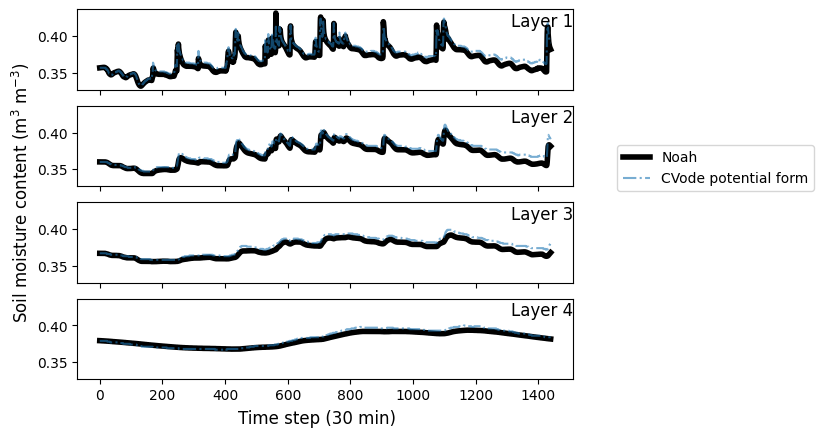

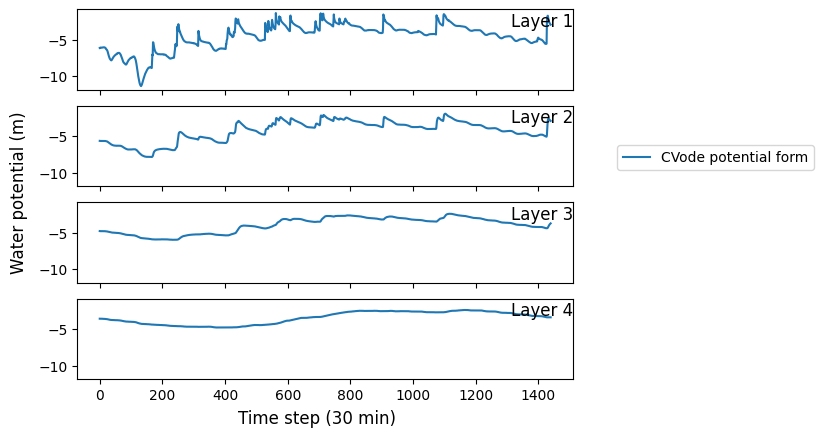

In [78]:
import matplotlib.pyplot as plt
import numpy as np

potential_df = pd.read_csv(
    'cycles.txt',
)
mixed_df = pd.read_csv(
    'cycles.mixed.txt',
)
moisture_df = pd.read_csv(
    'cycles.moisture.txt',
)
fig, axs = plt.subplots(
    4, 1,
    sharex=True,
    sharey=True,
)
for k in range(len(zsoil)):
    axs[k].plot(
        noah_df[f'SH2O{k+1}'],
        color='k',
        lw=4,
        label='Noah',
    )
    axs[k].plot(
        potential_df[f'smc{k}'],
        ls='dashdot',
        alpha=0.6,
        label='CVode potential form',
    )
    axs[k].set_title(
        f'Layer {k+1}',
        loc='right',
        y=1.0, pad=-12
    )
plt.legend(bbox_to_anchor=(1.5, 3))
fig.supxlabel('Time step (30 min)')
fig.supylabel('Soil moisture content (m$^3$ m$^{-3}$)')

fig, axs = plt.subplots(
    4, 1,
    sharex=True,
    sharey=True,
)
for k in range(len(zsoil)):
    axs[k].plot(
        df[f'psi{k}'],
        label='CVode potential form',
    )
    axs[k].set_title(
        f'Layer {k+1}',
        loc='right',
        y=1.0, pad=-12
    )
plt.legend(bbox_to_anchor=(1.5, 3))
fig.supxlabel('Time step (30 min)')
fig.supylabel('Water potential (m)')